In [141]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-sko6bn_m
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-sko6bn_m
  Created wheel for albumentations: filename=albumentations-0.5.2-cp37-none-any.whl size=88321 sha256=1f063f843819be18b9c2401d958054150aba86a71adfe80542a5c89a7e0077df
  Stored in directory: /tmp/pip-ephem-wheel-cache-u590v27l/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


# Step-1 :Import The necessary Library 

In [142]:
import os
import re
import ast
import cv2
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import albumentations as A
from PIL import Image
from matplotlib import pyplot as plt
#from tqdm import tqdm_notebook as tqdm
#from tqdm import tqdm 
from tqdm.notebook import tqdm as tqdm
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import FasterRCNN
from torch.utils.data.sampler import SequentialSampler
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Step-2: Load The Dataset In Colab 

In [143]:
df = pd.read_csv("/content/drive/MyDrive/yolov3/WebMarket_coco_gt_object.csv")
df.head()

,image_name,x1,y1,x2,y2,class
0,db1.jpg,1105,919,1315,1127,object
1,db1.jpg,191,1242,398,1469,object
2,db1.jpg,1587,697,1906,761,object
3,db1.jpg,1541,442,1845,541,object
4,db1.jpg,1252,505,1398,761,object


In [144]:
#Rename the Column Name 
df.rename(columns={'image_name': 'image_id',}, inplace=True)

In [145]:
df.head()

,image_id,x1,y1,x2,y2,class
0,db1.jpg,1105,919,1315,1127,object
1,db1.jpg,191,1242,398,1469,object
2,db1.jpg,1587,697,1906,761,object
3,db1.jpg,1541,442,1845,541,object
4,db1.jpg,1252,505,1398,761,object


In [146]:
# Shape of Dataframe
print(f"Shape of train DataFrame:{df.shape}")

Shape of train DataFrame:(118388, 6)


In [147]:
#Define The Path For the shop Market Images 
DATA_PATH='/content/drive/MyDrive/yolov3/data/'

In [148]:
TRAIN_DIR = os.path.join(DATA_PATH)

# Step-3: Train And Validation Splite 

In [149]:
train_split = 0.8
images_id   = df["image_id"].unique() 
train_ids   = images_id[:int(len(images_id)*train_split)]
valid_ids   = images_id[int(len(images_id)*train_split):]
print(f'Total Images Number: {len(images_id)}')
print(f'Number of training images: {len(train_ids)}')
print(f'Number of Valid images: {len(valid_ids)}')

Total Images Number: 3151
Number of training images: 2520
Number of Valid images: 631


In [150]:
train_df = df[df["image_id"].isin(train_ids)]
valid_df = df[df["image_id"].isin(valid_ids)]

print(f'Shape of train_df: {train_df.shape}')
print(f'Shape of valid_df: {valid_df.shape}')

Shape of train_df: (95836, 6)
Shape of valid_df: (22552, 6)


In [151]:
# Data Transform - Albumentation
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [152]:
class marketDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        super().__init__()
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = dataframe["image_id"].unique()
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        details = self.dataframe[self.dataframe["image_id"]==image_id]
        img_path = os.path.join(TRAIN_DIR, image_id)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        print(image)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Row of Dataframe of a particular index.
        boxes = details[['x1', 'y1', 'x2', 'y2']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        #To find area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        #COnvert it into tensor dataType
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((details.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((details.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx) ### <------------ New change list has been removed
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            
            sample = self.transform(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.long)
        
        return image, target     #, image_id
    
    def __len__(self) -> int:
        return len(self.image_ids)

In [153]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [154]:
train_dataset = marketDataset(train_df, TRAIN_DIR, get_train_transform())
valid_dataset = marketDataset(valid_df, TRAIN_DIR, get_valid_transform())
print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of test_dataset: {len(valid_dataset)}")

Length of train_dataset: 2520
Length of test_dataset: 631


In [129]:
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Step-4:Visualise Some Images From the Dataset 

In [130]:
def plot_images(n_num, random_selection=True):

    if random_selection:
        index = random.sample(range(0, len(train_df["image_id"].unique())-1), n_num)
    else:
        index = range(0, n_num)
    plt.figure(figsize=(15,15))
    fig_no = 1
    
    for i in index:
        images, targets = train_dataset.__getitem__(i)
        sample = np.array(np.transpose(images, (1,2,0)))
        boxes = targets["boxes"].numpy().astype(np.int32)
    
        #Plot figure/image

        for box in boxes:
            cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(255,223,0), 2)
        plt.subplot(n_num/2, n_num/2, fig_no)
        plt.imshow(sample)
        fig_no+=1

In [ ]:
plot_images(4)#It Didnt Work That's Why i use other But i try it 

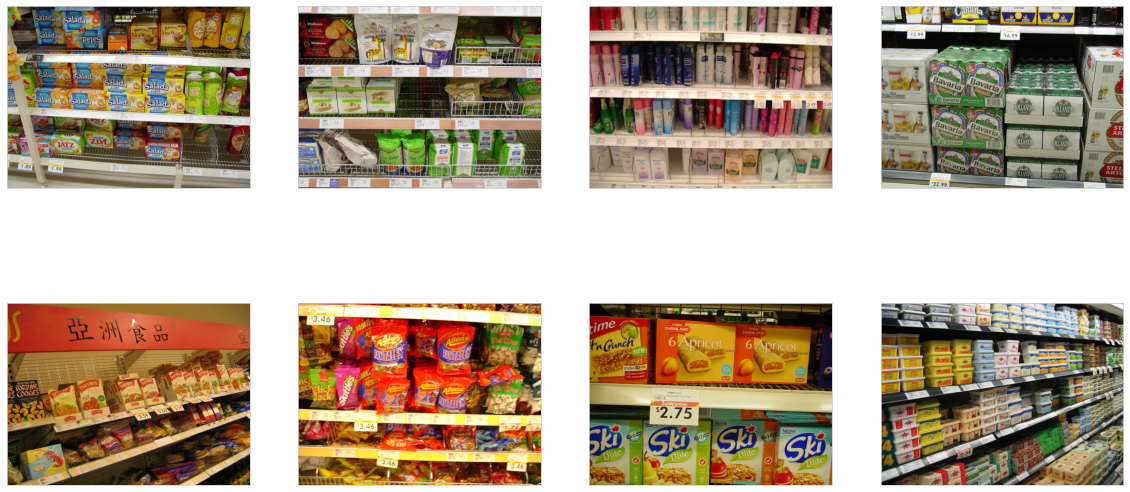

In [137]:
# Visualizing some samples from the training set

sample_indices = np.random.choice(np.unique(df["image_id"].tolist()), 8)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
count=0

for row in ax:
    for col in row:
        img = plt.imread("/content/drive/MyDrive/yolov3/data/" + sample_indices[count] )
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        count += 1
plt.show()


In [139]:
# Visualize the images with bounding boxes
import matplotlib.patches as patches

def get_bbox(image_id, df, col, color='white'):
    bboxes = df[df['image_id'] == image_id]
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes['x1'].iloc[i], bboxes['y1'].iloc[i]),
            bboxes['x2'].iloc[i], 
            bboxes['y2'].iloc[i], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)


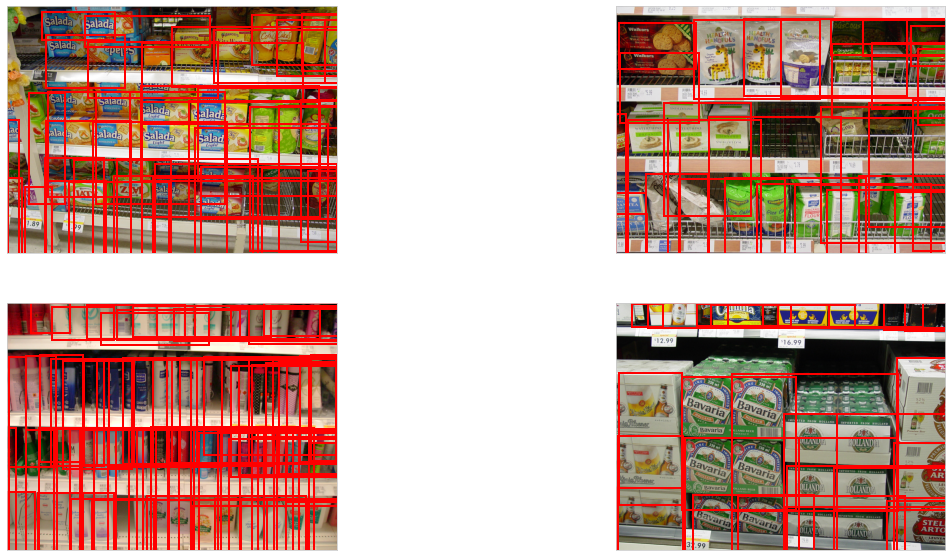

In [140]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
count=0
for row in ax:
    for col in row:
        img = plt.imread("/content/drive/MyDrive/yolov3/data/" + sample_indices[count])
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        get_bbox(sample_indices[count], df, col, color='red')
        col.imshow(img)
        count += 1
plt.show()


# Step-5:Model Declaration 

In [132]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

In [133]:
print(model)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [134]:
num_classes = 1  # 1 class  

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [135]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 8

In [ ]:
import time

itr=1

total_train_loss = []
total_valid_loss = []

losses_value = 0
for epoch in range(num_epochs):
  
    start_time = time.time()
    train_loss = []
    model.train()
    
    #<-----------Training Loop---------------------------->
    pbar = tqdm(train_data_loader, desc = 'description')
    for images, targets in pbar:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        losses_value = losses.item()
        train_loss.append(losses_value)        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, loss: {losses_value}")
        itr+=1

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    
    
    #<---------------Validation Loop---------------------->
    with torch.no_grad():
        valid_loss = []

        for images, targets in valid_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # If you need validation losses
            model.train()
            # Calculate validation losses
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            valid_loss.append(loss_value)
            
    epoch_valid_loss = np.mean(valid_loss)
    total_valid_loss.append(epoch_valid_loss)
    
    print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time},\
    Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

# step-6: Ploting The Loss And Accuracy Chart 

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.set_style(style="whitegrid")
sns.lineplot(range(1, len(total_train_loss)+1), total_train_loss, label="Training Loss")
sns.lineplot(range(1, len(total_train_loss)+1), total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


# Step-7: Save The Model 

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_best_resnet50.pth')